In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Estimating $\Omega$ & $\Lambda$ with All Distributions (Jensen-Shannon Distance)

#### Testing Plot

In [ ]:
size = (20,10)
x = np.linspace(10, 100, size[0])
y = np.linspace(10, 50, size[1])
z = np.zeros(size)
for i in range(size[0]):
    for j in range(size[1]):
        x0 = [x[i], y[j]]
        z[i,j] = jsd(x0, 0)

/users/chi-kit.ng/src/pop_models_lvk/population_models/mass.py:10: RuntimeWarning: overflow encountered in exp
  p[idx]       = 1./(1.+np.exp(exponent))


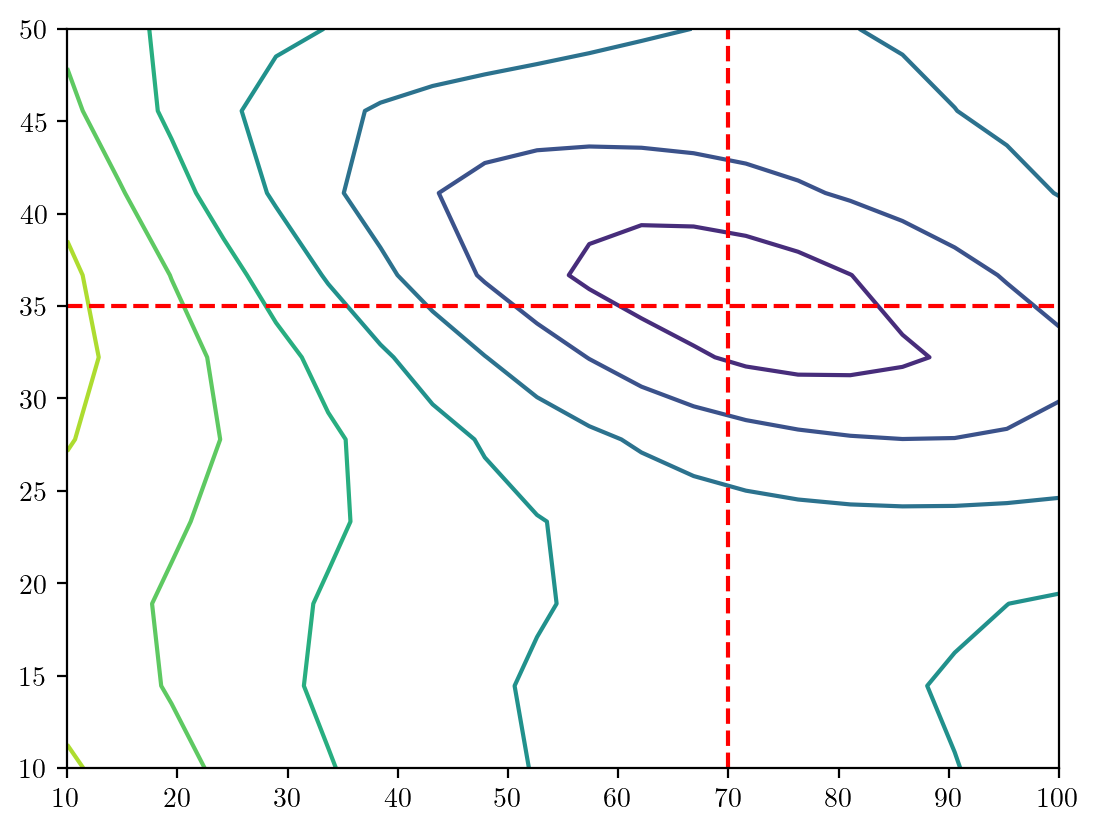

In [ ]:
plt.contour(x, y, z.T)
plt.axvline(70, color='r', linestyle='--')
plt.axhline(35, color='r', linestyle='--')

#### Testing

In [ ]:
from scipy.spatial.distance import jensenshannon as scipy_jsd
from scipy.optimize import minimize as scipy_minimize
from numpy.random import uniform as uni
from figaro.cosmology import CosmologicalParameters
from population_models.mass import plpeak

# dL distributions
def DLsq(DL, DLmax = 5000):
    return 3*DL**2/DLmax**3

pdf_figaro, mz, dL = [np.load('./result/result_multi_intermediate.npz')[parameter] for parameter in ['pdf_figaro', 'mz', 'dL']]

In [ ]:
x0 = [uni(10,100), uni(10,50)]
bounds = ((10,100), (10,50))

i = 0

def plp(m, x):
    return plpeak(m, mu=x[0])

def jsd(x, i):
    z = CosmologicalParameters(x[0]/100, 0.315, 0.685, -1., 0., 0.).Redshift(dL)
    m = np.einsum("i, j -> ij", mz, np.reciprocal(1+z))
    
    p = np.einsum("ij, j -> ij", plp(m, x[1:]), DLsq(dL))
    p = np.sum(p, axis=1) # delta_dL and normalization of mz is included in scipy_jsd

    return scipy_jsd(p, pdf_figaro[i])

In [ ]:
jsd([70,35], i)
# 2.5s

0.06080872753932336

In [ ]:
scipy_minimize(jsd, x0=x0, bounds=bounds, args=(i,), method='Nelder-Mead').x
# 6m 5s (wrong result)

array([69.79406888, 10.        ])

In [ ]:
scipy_minimize(jsd, x0=x0, bounds=bounds, args=(i,), method='Powell').x
# 4m 8s

/users/chi-kit.ng/src/pop_models_lvk/population_models/mass.py:10: RuntimeWarning: overflow encountered in exp
  p[idx]       = 1./(1.+np.exp(exponent))


array([70.2169537 , 35.40362984])

In [ ]:
scipy_minimize(jsd, x0=x0, bounds=bounds, args=(i,), method='L-BFGS-B').x
# 1m 48s

array([70.22168951, 35.40244468])

In [ ]:
scipy_minimize(jsd, x0=x0, bounds=bounds, args=(i,), method='TNC').x
# 6m 39s

array([70.2176632 , 35.40346237])

In [ ]:
scipy_minimize(jsd, x0=x0, bounds=bounds, args=(i,), method='COBYLA').x
# 8m 55s

array([70.21874801, 35.40323823])

In [ ]:
scipy_minimize(jsd, x0=x0, bounds=bounds, args=(i,), method='SLSQP').x
# 2m 26s

array([70.21548045, 35.40289703])

In [ ]:
scipy_minimize(jsd, x0=x0, bounds=bounds, args=(i,), method='trust-constr').x
# 2m 47s

/users/chi-kit.ng/.conda/envs/population/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


array([70.21696298, 35.40364617])

In [ ]:
import cma

xopt, es = cma.fmin2(jsd, x0, 1, {'bounds': np.array(bounds).T.tolist(), 'CMA_stds': np.array(bounds).T[1]/4}, args=(i,))

xopt
# 24m 19s

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=443494, Wed Mar 13 10:51:50 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 1.404499255708944e-01 1.0e+00 1.20e+00  1e+01  3e+01 0:15.7
    2     12 1.349601426049606e-01 1.4e+00 1.76e+00  1e+01  3e+01 0:30.9
    3     18 1.201641424445074e-01 1.6e+00 1.53e+00  1e+01  2e+01 0:45.9
    4     24 1.436757249785598e-01 2.0e+00 1.31e+00  1e+01  2e+01 1:01.7
    5     30 1.732528810841194e-01 2.8e+00 1.12e+00  9e+00  1e+01 1:18.0
    6     36 1.333787232811059e-01 2.7e+00 1.26e+00  1e+01  2e+01 1:34.1
    7     42 1.181139871217033e-01 2.5e+00 1.15e+00  9e+00  1e+01 1:49.9
    8     48 8.352419663304532e-02 3.0e+00 1.06e+00  7e+00  1e+01 2:06.5
    9     54 9.398012054611680e-02 2.7e+00 9.65e-01  6e+00  8e+00 2:21.6
   10     60 9.163786067759078e-02 2.5e+00 9.07e-01  4e+00  8e+00 2:37.3
   11     66 9.931311225102225e-02 2.1e+00 7.60e-01  3e+00  6e+00 2:52.3
   12     72 9.559053022044992e-02 

array([70.18197248, 35.4036441 ])

In [ ]:
def jsd_ps(x, i):
    return np.array([jsd(x[j], i) for j in range(len(x))])

import pyswarms as ps

options = {'c1': 0.5, 'c2': 0.3, 'w':0.9, 'k': 2, 'p': 2}

optimizer = ps.single.LocalBestPSO(n_particles=10, dimensions=len(x0), options=options, bounds=tuple(np.array(bounds).T))

cost, pos = optimizer.optimize(jsd_ps, iters=100, i=i)

pos
# 46m 34s

2024-03-13 11:41:05,409 - pyswarms.single.local_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 2, 'p': 2}
pyswarms.single.local_best:   0%|          |0/100/users/chi-kit.ng/src/pop_models_lvk/population_models/mass.py:10: RuntimeWarning: overflow encountered in exp
  p[idx]       = 1./(1.+np.exp(exponent))
pyswarms.single.local_best: 100%|██████████|100/100, best_cost=0.06 
2024-03-13 12:27:39,469 - pyswarms.single.local_best - INFO - Optimization finished | best cost: 0.05995798409232651, best pos: [70.17482193 35.40935457]


array([70.17482193, 35.40935457])

#### Plots

Nelder-Mead
$H_0$ = 67.17474038887995 +/- 2.9534259305229273
$\mu$ = 21.117630631520324 +/- 12.637125287692344


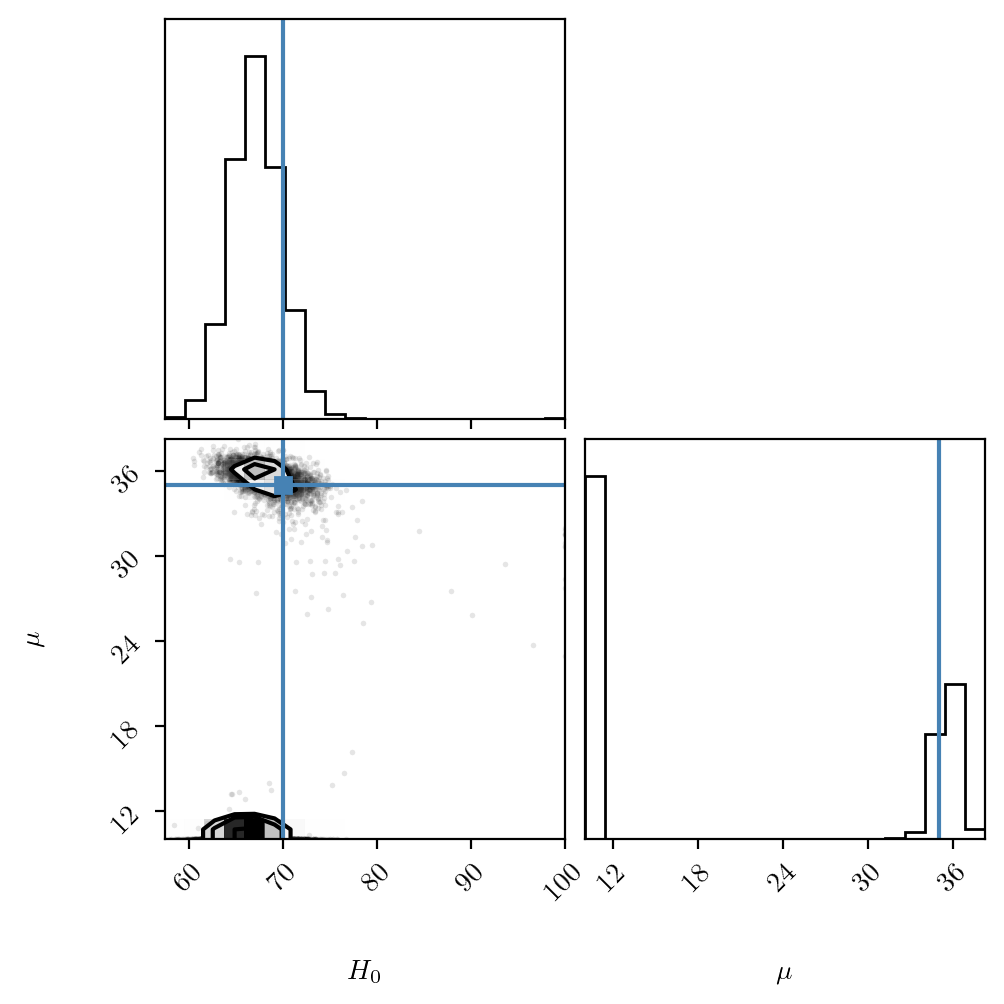

Powell
$H_0$ = 68.93755957099086 +/- 2.390701134801845
$\mu$ = 34.77783945231897 +/- 0.8694836003049273


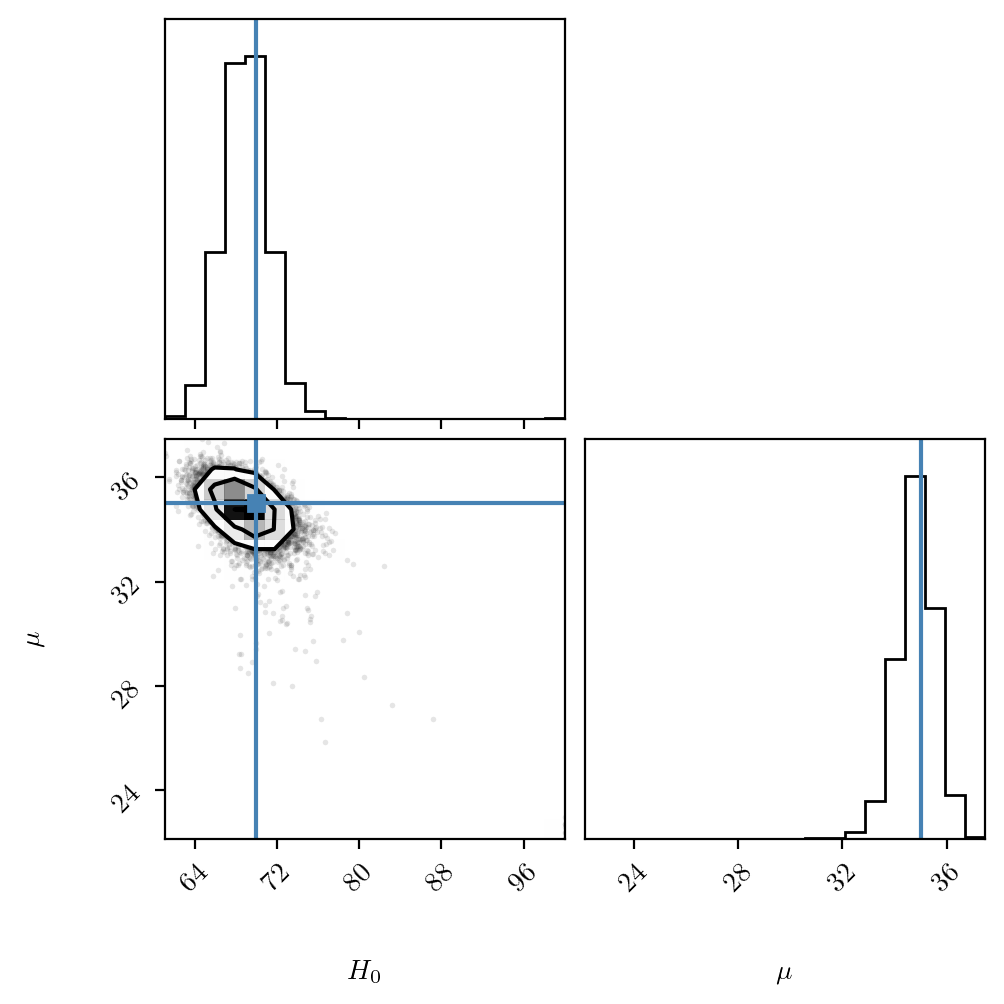

L-BFGS-B
$H_0$ = 65.22938309981225 +/- 2.437001781884035
$\mu$ = 35.03739508441463 +/- 1.9264395027036836


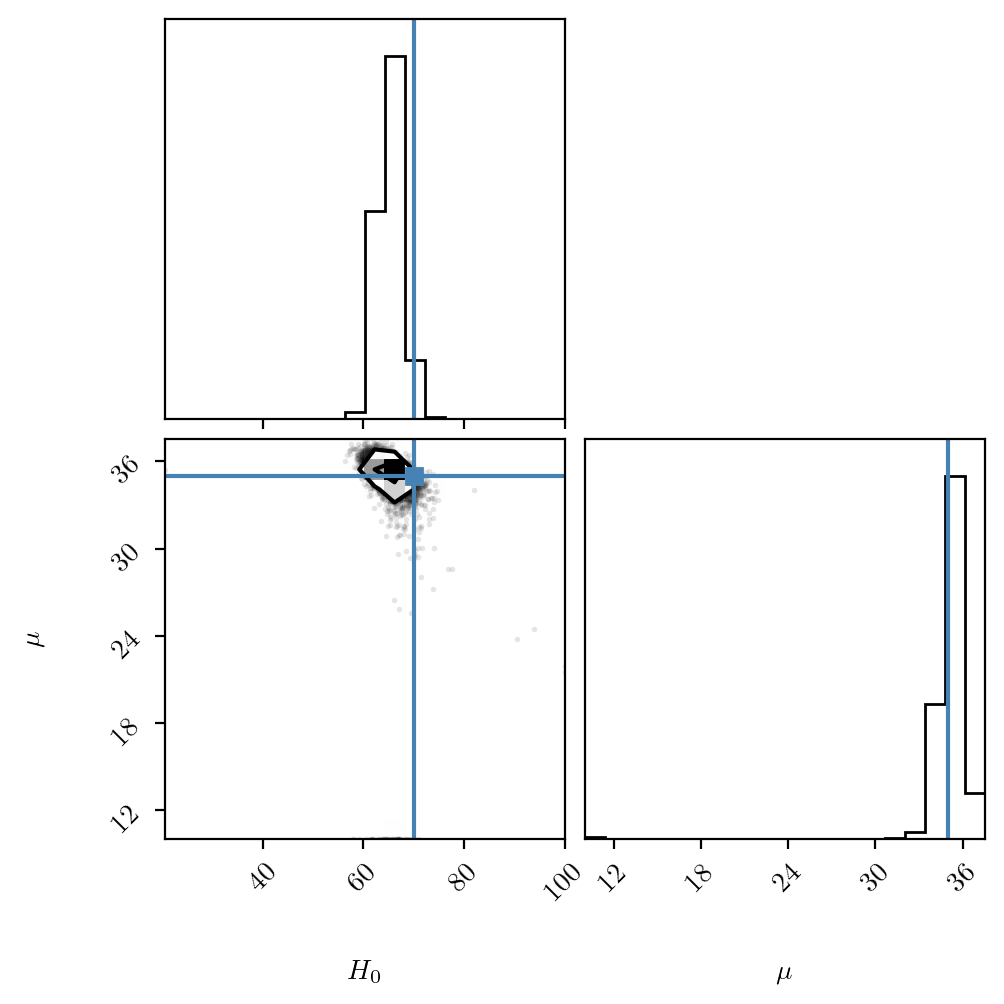

TNC
$H_0$ = 69.80054217077625 +/- 2.5458380516581824
$\mu$ = 34.102814768017446 +/- 0.8461081919496132


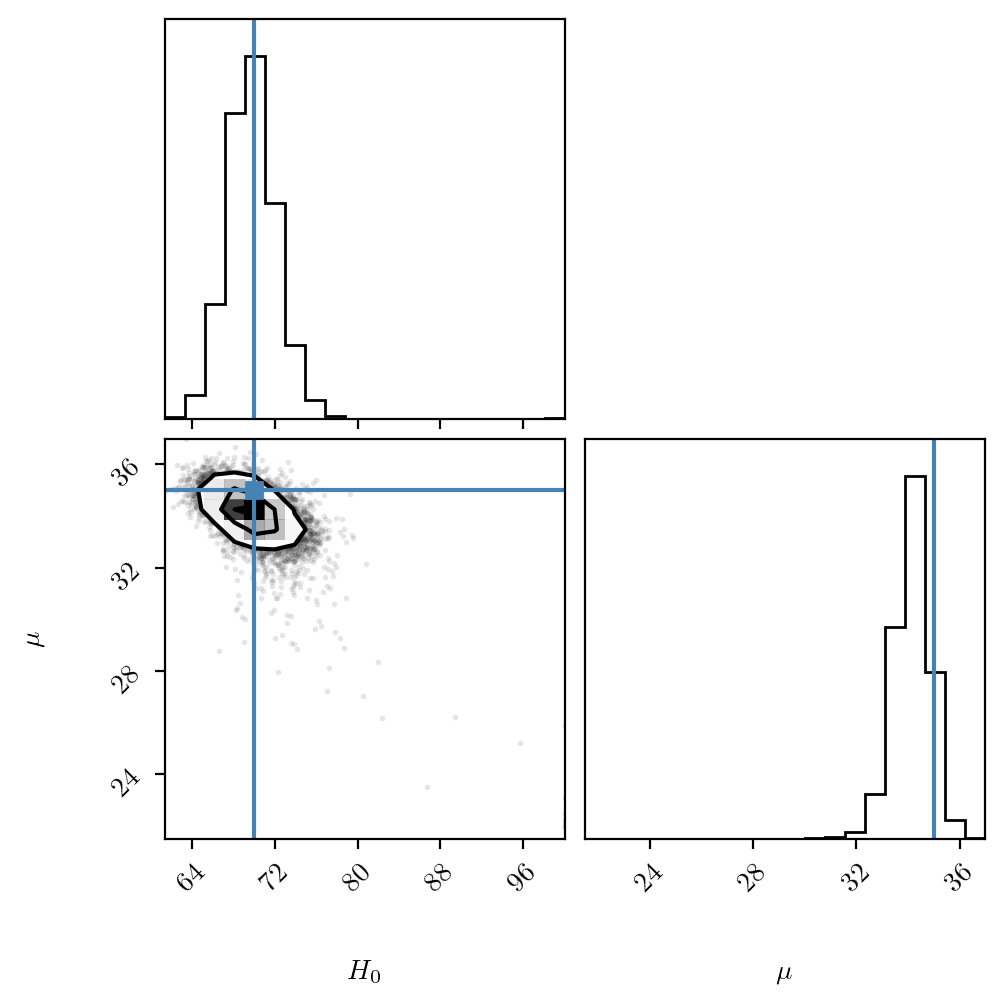

COBYLA
$H_0$ = 67.52069257557548 +/- 2.521453107592566
$\mu$ = 35.03952167093324 +/- 0.7767968534289358


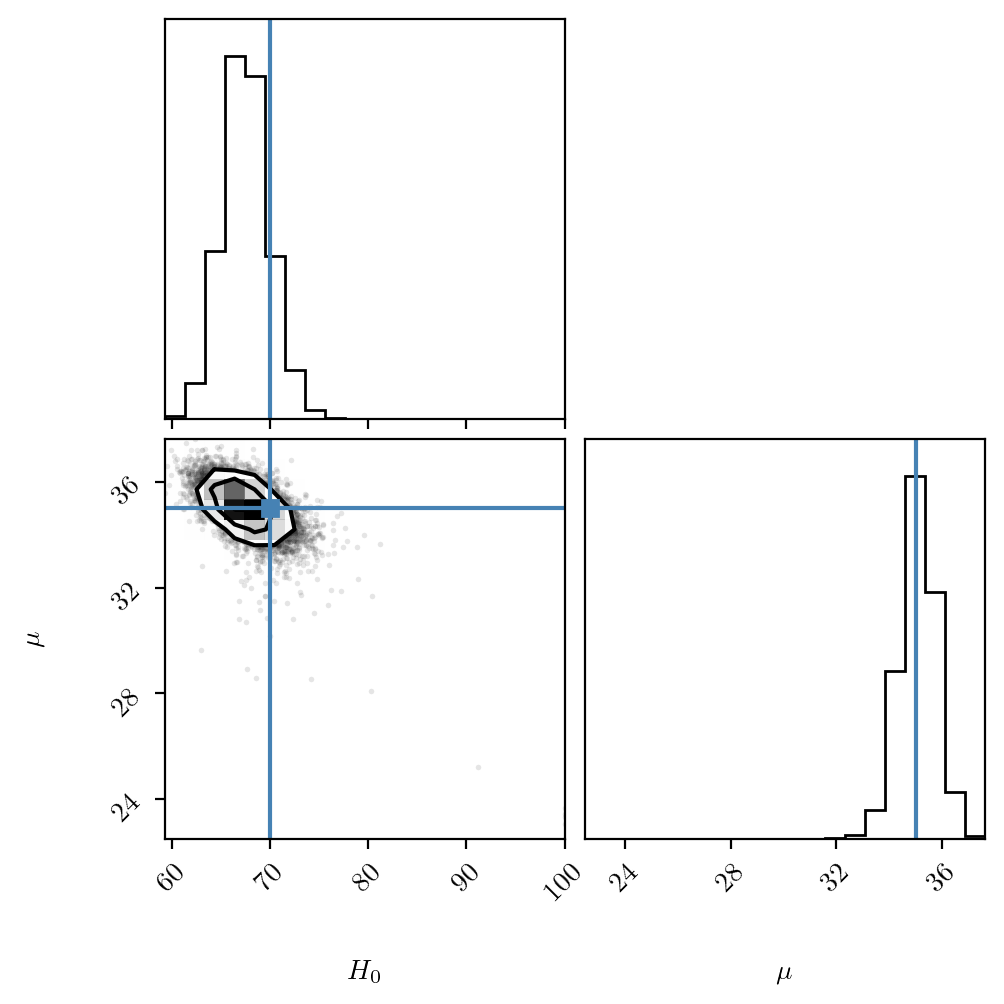

SLSQP
$H_0$ = 66.17992737045375 +/- 2.407681805556138
$\mu$ = 35.35279101849443 +/- 0.8882290511378356


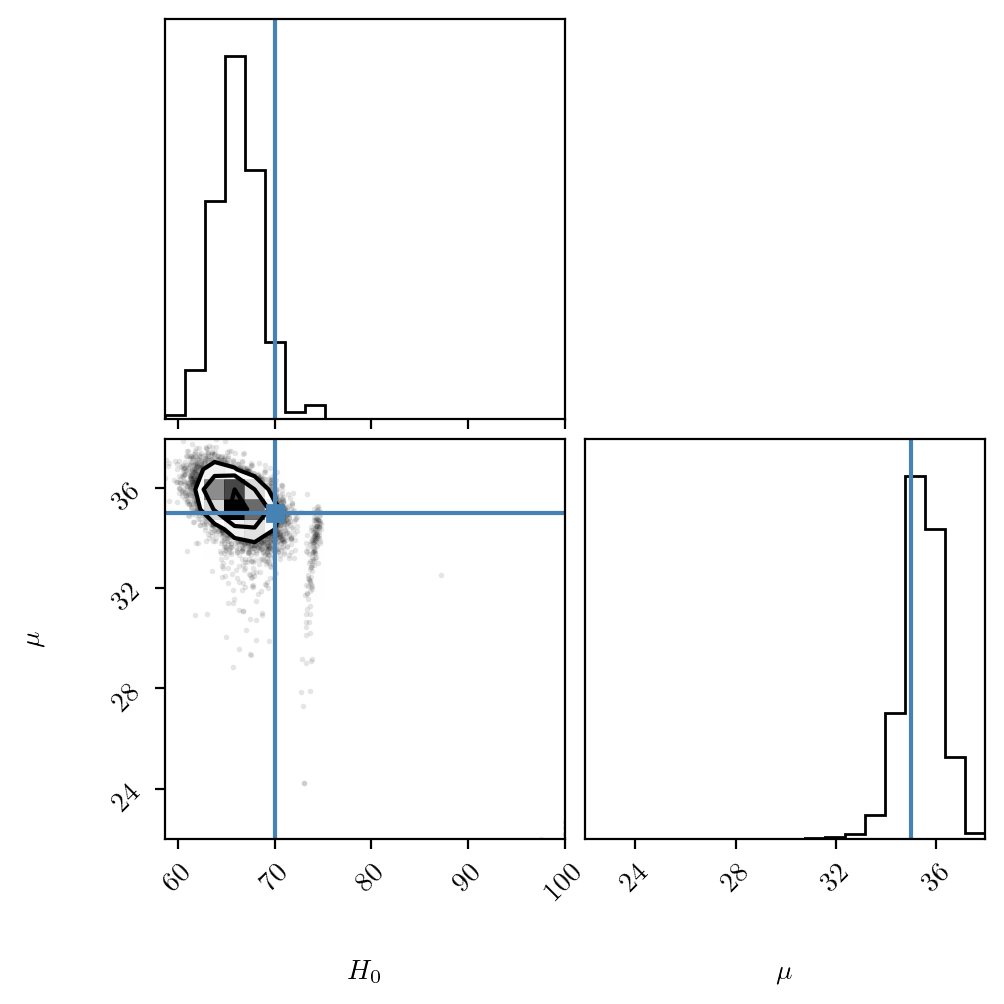

trust-constr
$H_0$ = 68.41095130283956 +/- 2.670626386944268
$\mu$ = 34.37920391621524 +/- 1.0119985212898166


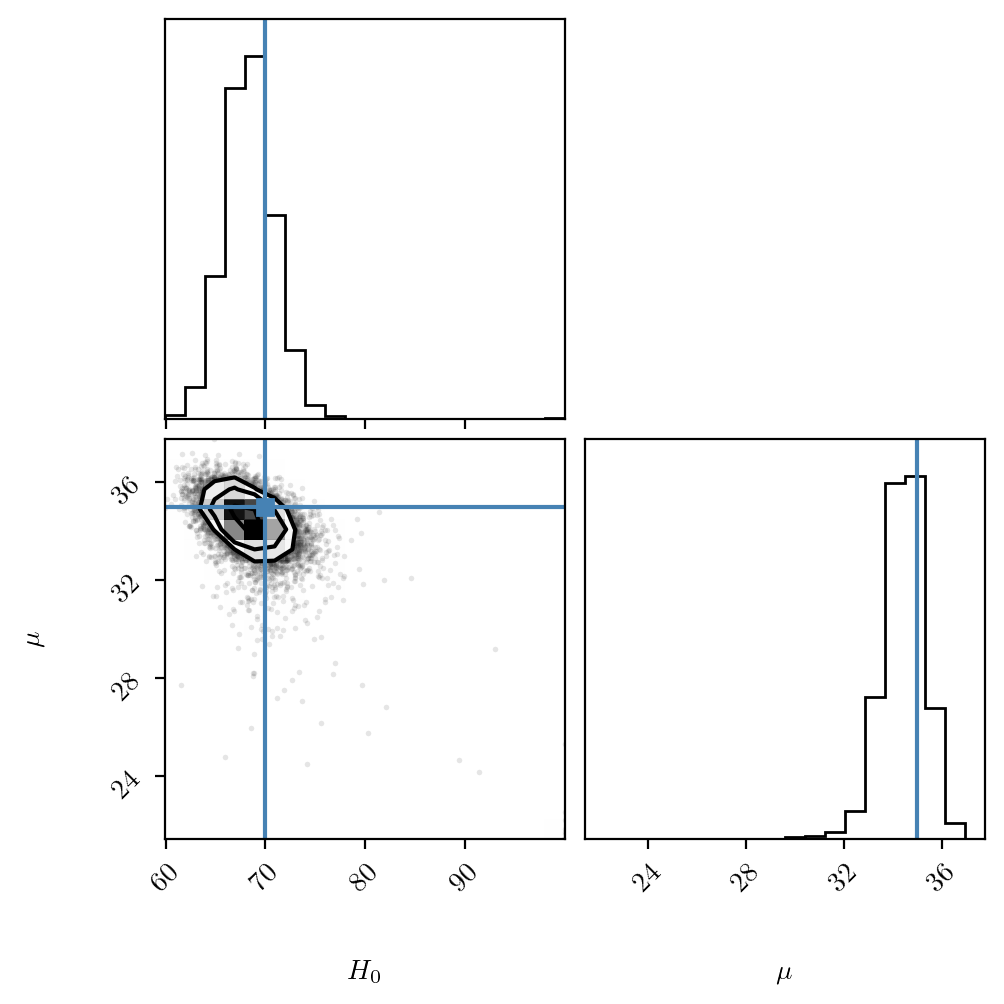

An exception occurred: [Errno 2] No such file or directory: './result/result_mu_CMA-ES.npz'
An exception occurred: [Errno 2] No such file or directory: './result/result_mu_PSO.npz'


In [4]:
for method in ['Nelder-Mead', 'Powell', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'trust-constr', 'CMA-ES', 'PSO']:
    try:
        f = np.load("./result/result_mu_"+method+".npz")
        result = f['result']
        # mz_sample = f['Mz_sample']
        # figaro_pdf = f['pdf_figaro']

        print(method)
        for i, label in enumerate(["$H_0$", "$\\mu$"]):
            print(label+" = "+str(result[:,i].mean())+" +/- "+str(result[:,i].std()))

        corner(result, labels = ["$H_0$", "$\\mu$"], truths=[70, 35])
        # plt.savefig("./corner_H0_mu.pdf", bbox_inches='tight')
        plt.show()
    except Exception as e:
        print("An exception occurred:", e)
        pass

Nelder-Mead
$H_0$ = 69.08555144321693 +/- 3.6427117197318597
$\alpha$ = 3.539134309496738 +/- 0.27538990580842754


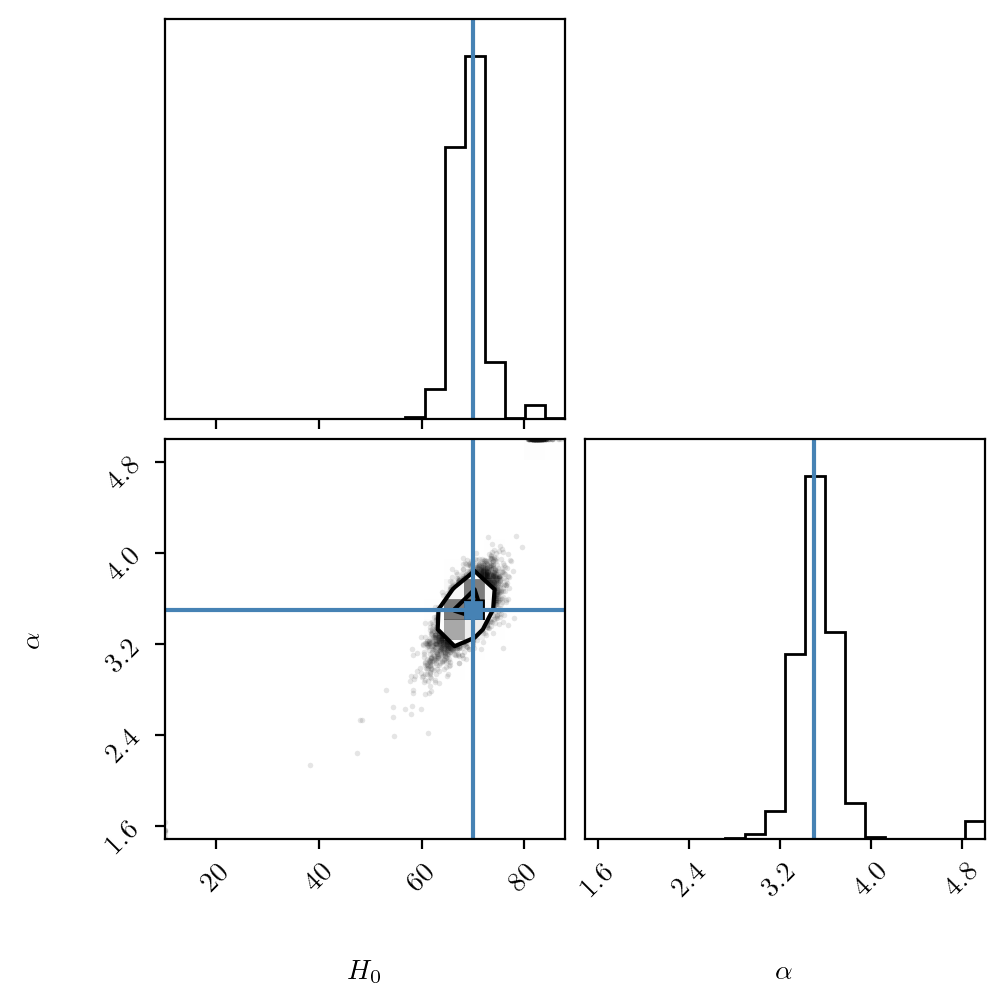

Powell
$H_0$ = 65.71762615072744 +/- 2.6187654560866362
$\alpha$ = 3.5479084513066184 +/- 0.15446900536417738


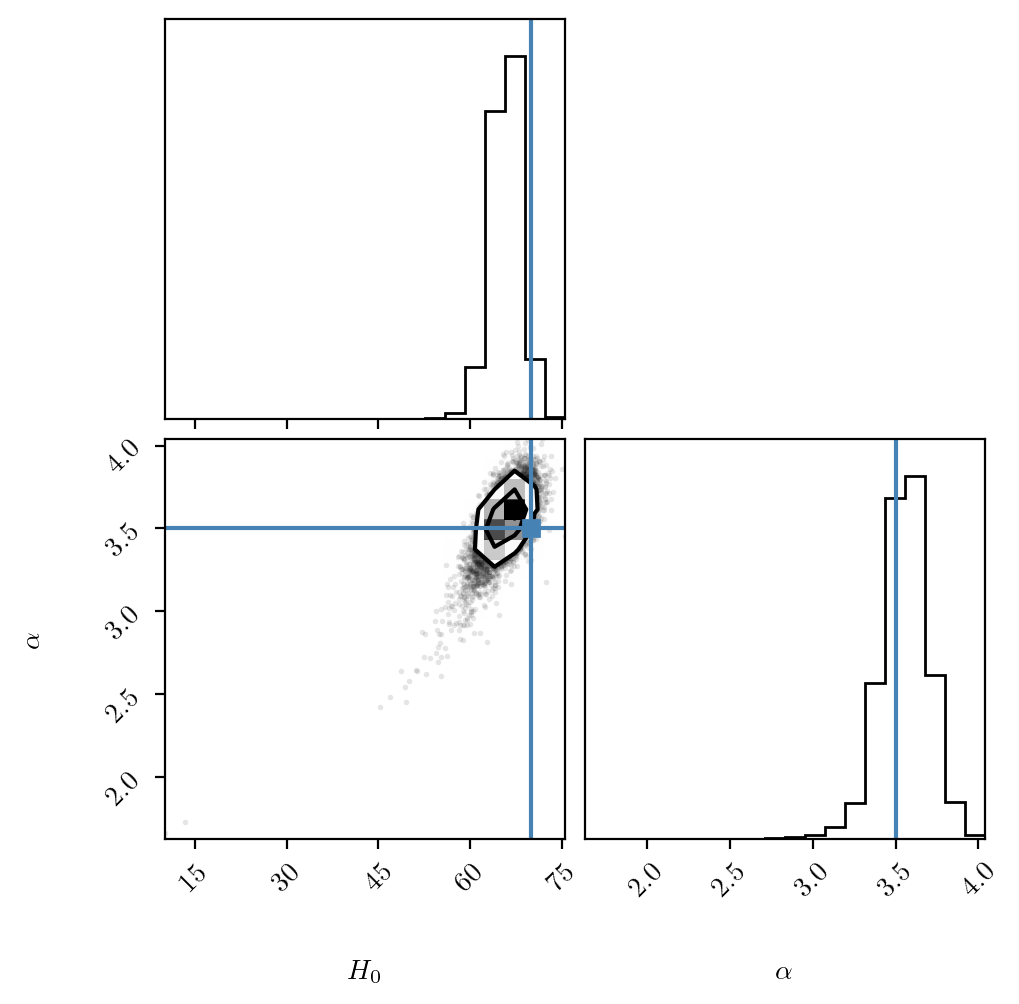

L-BFGS-B
$H_0$ = 68.48082576464296 +/- 2.927495594432567
$\alpha$ = 3.4485656673596985 +/- 0.16151466997651062


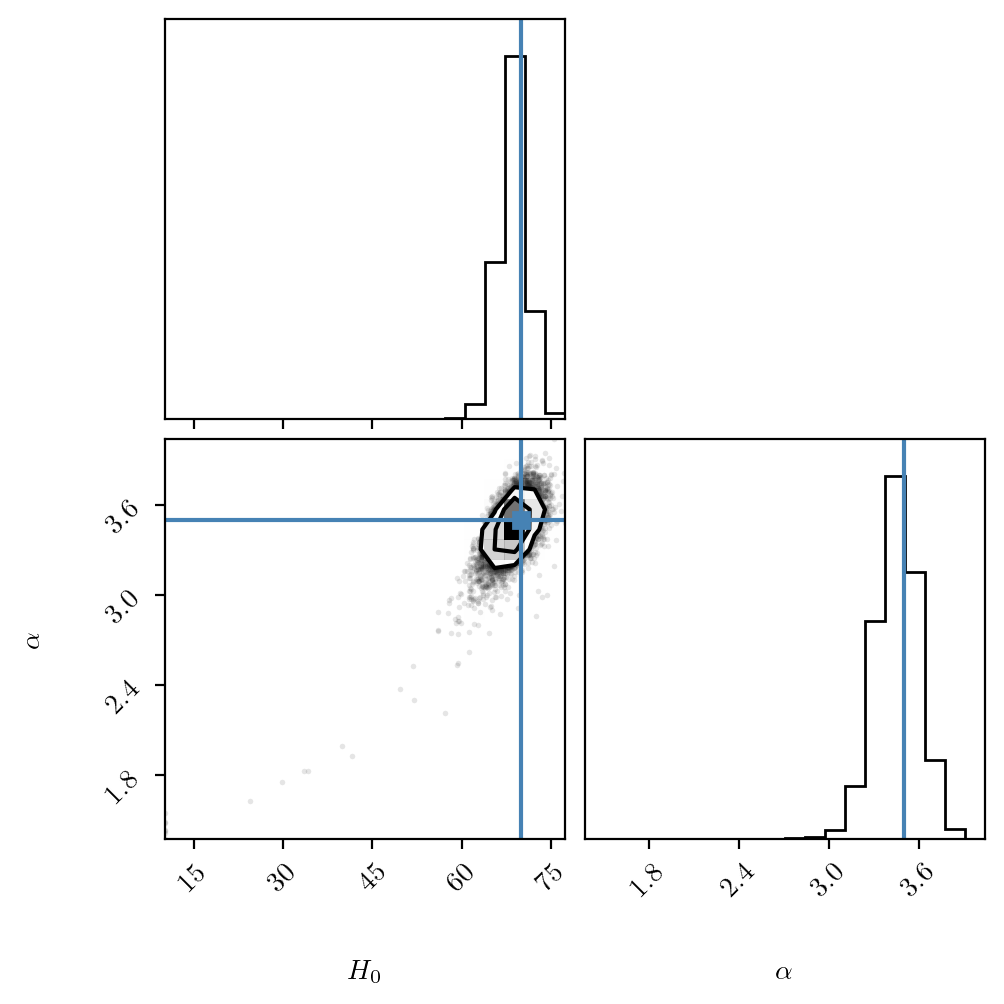

TNC
$H_0$ = 70.23609140747944 +/- 2.85607738936641
$\alpha$ = 3.5853182166870443 +/- 0.1738292603028852


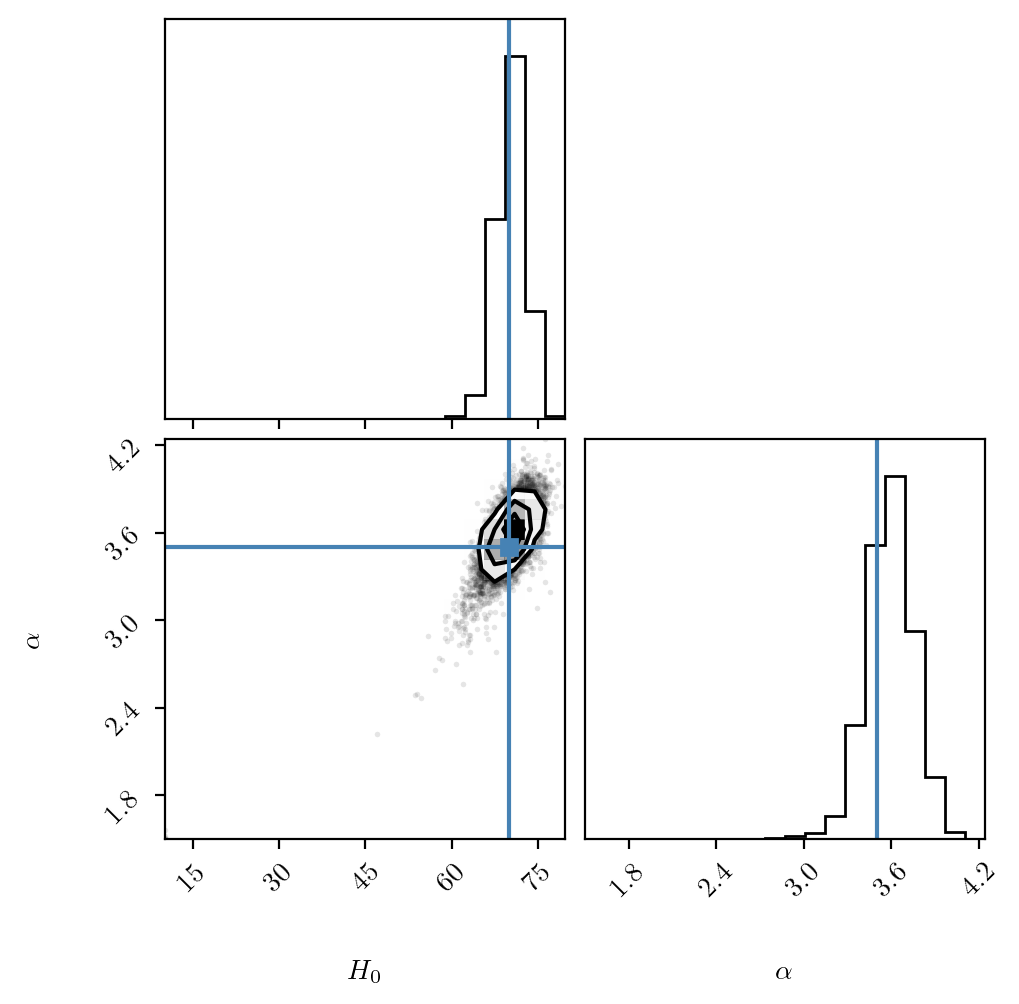

An exception occurred: [Errno 2] No such file or directory: './result/result_alpha_COBYLA.npz'
SLSQP
$H_0$ = 66.56661771643599 +/- 3.1034204166781123
$\alpha$ = 3.4950739662618777 +/- 0.16936472822925505


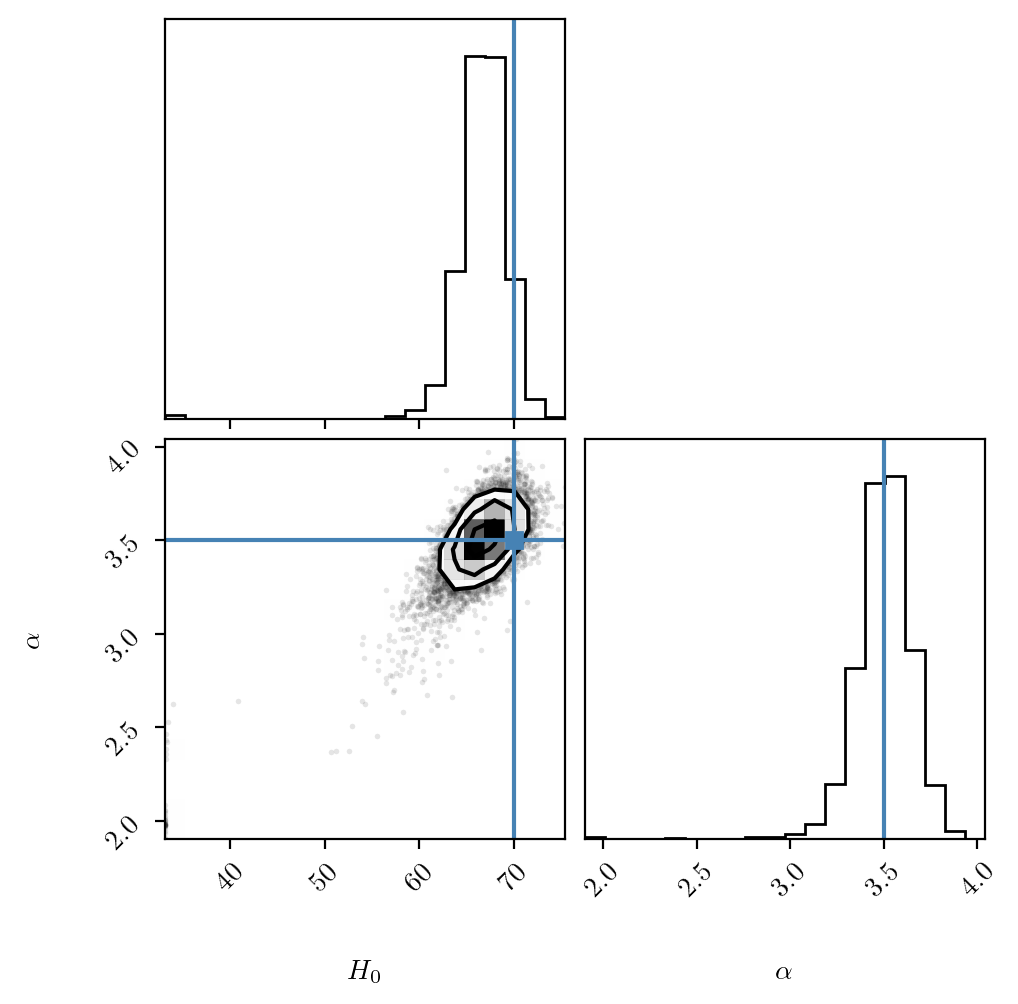

An exception occurred: [Errno 2] No such file or directory: './result/result_alpha_trust-constr.npz'
An exception occurred: [Errno 2] No such file or directory: './result/result_alpha_CMA-ES.npz'
An exception occurred: [Errno 2] No such file or directory: './result/result_alpha_PSO.npz'


In [5]:
for method in ['Nelder-Mead', 'Powell', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'trust-constr', 'CMA-ES', 'PSO']:
    try:
        f = np.load("./result/result_alpha_"+method+".npz")
        result = f['result']
        # mz_sample = f['Mz_sample']
        # figaro_pdf = f['pdf_figaro']

        print(method)
        for i, label in enumerate(["$H_0$", "$\\alpha$"]):
            print(label+" = "+str(result[:,i].mean())+" +/- "+str(result[:,i].std()))

        corner(result, labels = ["$H_0$", "$\\alpha$"], truths=[70, 3.5])
        # plt.savefig("./corner_H0_alpha.pdf", bbox_inches='tight')
        plt.show()
    except Exception as e:
        print("An exception occurred:", e)
        pass

An exception occurred: [Errno 2] No such file or directory: './result/result_5_Nelder-Mead.npz'
An exception occurred: [Errno 2] No such file or directory: './result/result_5_Powell.npz'
An exception occurred: [Errno 2] No such file or directory: './result/result_5_L-BFGS-B.npz'
An exception occurred: [Errno 2] No such file or directory: './result/result_5_TNC.npz'
An exception occurred: [Errno 2] No such file or directory: './result/result_5_SLSQP.npz'
trust-constr
$H_0$ = 69.06138070841659 +/- 3.794291338482799
$\alpha$ = 3.587726645012484 +/- 0.2571382853368822
$\mu$ = 34.27933943366471 +/- 1.2623606232966824
$\sigma$ = 5.693363711566766 +/- 0.9956166404738278
$w$ = 0.20683760839633755 +/- 0.023654372320157966


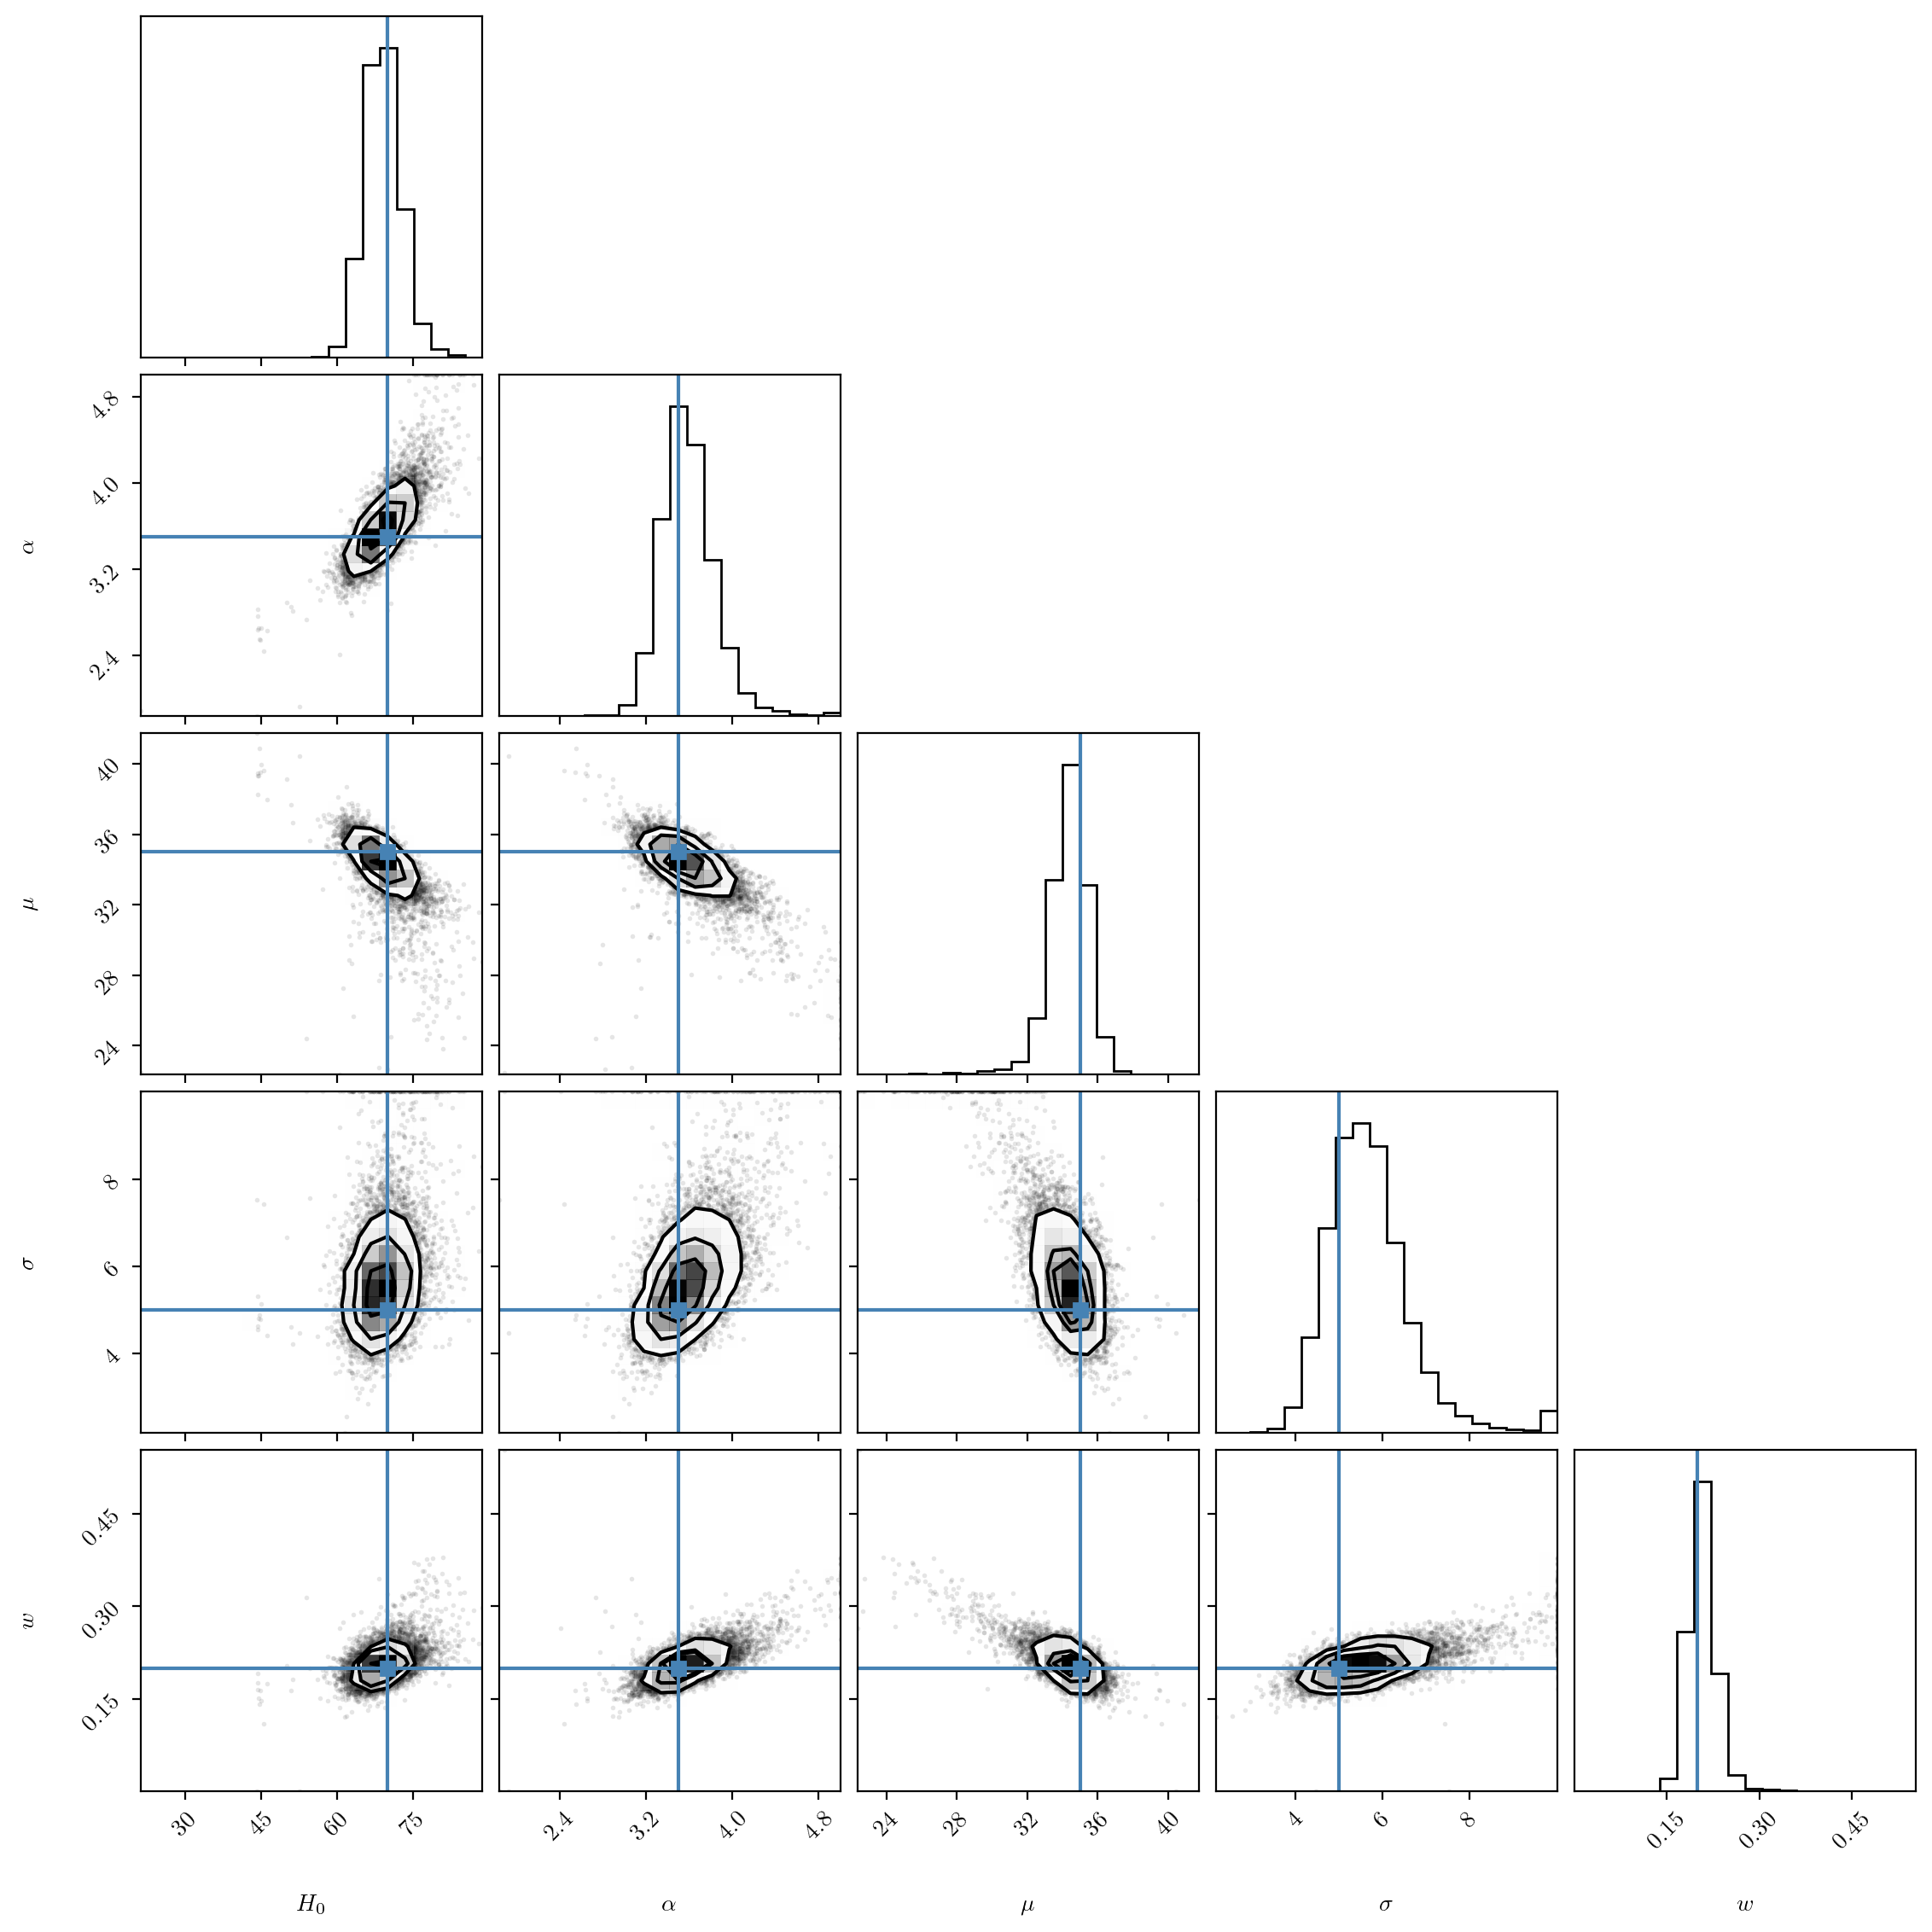

An exception occurred: [Errno 2] No such file or directory: './result/result_5_CMA-ES.npz'
An exception occurred: [Errno 2] No such file or directory: './result/result_5_PSO.npz'


In [6]:
for method in ['Nelder-Mead', 'Powell', 'L-BFGS-B', 'TNC', 'SLSQP', 'trust-constr', 'CMA-ES', 'PSO']:
    try:
        f = np.load("./result/result_5_"+method+".npz")
        result = f['result']
        # mz_sample = f['Mz_sample']
        # figaro_pdf = f['pdf_figaro']

        print(method)
        for i, label in enumerate(["$H_0$", "$\\alpha$", "$\\mu$", "$\\sigma$", "$w$"]):
            print(label+" = "+str(result[:,i].mean())+" +/- "+str(result[:,i].std()))

        corner(result, labels = ["$H_0$", "$\\alpha$", "$\\mu$", "$\\sigma$", "$w$"], truths = [70, 3.5, 35, 5, 0.2])
        plt.show()
    except Exception as e:
        print("An exception occurred:", e)
        pass

In [7]:
for method in ['Nelder-Mead', 'Powell', 'L-BFGS-B', 'TNC', 'SLSQP', 'trust-constr', 'CMA-ES', 'PSO']:
    try:
        f = np.load("./result/result_8_"+method+".npz")
        result = f['result']
        # mz_sample = f['Mz_sample']
        # figaro_pdf = f['pdf_figaro']

        print(method)
        for i, label in enumerate(["$H_0$", "$\\alpha$", "$\\mu$", "$\\sigma$", "$w$", "$M_{min}$", "$M_{max}$", "$\\delta$"]):
            print(label+" = "+str(result[:,i].mean())+" +/- "+str(result[:,i].std()))

        corner(result, labels = ["$H_0$", "$\\alpha$", "$\\mu$", "$\\sigma$"], truths = [70, 3.5, 35, 5])
        plt.show()
    except Exception as e:
        print("An exception occurred:", e)
        pass

An exception occurred: [Errno 2] No such file or directory: './result/result_8_Nelder-Mead.npz'
An exception occurred: [Errno 2] No such file or directory: './result/result_8_Powell.npz'
An exception occurred: [Errno 2] No such file or directory: './result/result_8_L-BFGS-B.npz'
An exception occurred: [Errno 2] No such file or directory: './result/result_8_TNC.npz'
An exception occurred: [Errno 2] No such file or directory: './result/result_8_SLSQP.npz'
An exception occurred: [Errno 2] No such file or directory: './result/result_8_trust-constr.npz'
An exception occurred: [Errno 2] No such file or directory: './result/result_8_CMA-ES.npz'
An exception occurred: [Errno 2] No such file or directory: './result/result_8_PSO.npz'
